# REGRESIÓN LOGÍSTICA

La regresión logística es una variante de los modelos lineales en los que el valor que se predice se acota entre 0 y 1, representando la probabilidad de que ocurra un evento, por lo que se aplica a lo que se denomina *clasificación binaria*. La ecuación general de los modelos lineales se modifica así:

## $\log \frac{p}{1 - p} = b_0 + b_1 x_1 + b_2 x_2 + \cdots + b_n x_n$

## $predicción = sigmoid(b_0 + b_1 x_1 + b_2 x_2 + \cdots + b_n x)$

donde ahora $p$ representa la probabilidad de que ocurra el evento que se estudia (por ejemplo, que un paciente al que se le hace un análisis de sangre tenga un tumor maligno o no). Cuando se hace una predicción usando un modelo de regresión logística sobre nuevos datos, se obtiene un número entre 0 y 1 que se suele denominar *score*. Si supera cierto valor umbral (denominado también *punto de corte*) entonces se considera que se va a producir el evento. Por tanto, no solo hay que entrenar el modelo, además hay que elegir un valor umbral que sea óptimo. Para ello se utilizan las curvas ROC (Receiver Operating Characteristic).

## Imports

In [98]:
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import linear_model    # LogisticRegression
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__)

Pandas   1.5.3
Sklearn  1.2.2


## Get the dataset

In [99]:
!wget -P ./../../Datasets/Tabular/  https://raw.githubusercontent.com/pbonillor/DATA_SCIENCE_CON_PYTHON/main/MODULO_IV/titanic_train.csv
!wget -P ./../../Datasets/Tabular/  https://raw.githubusercontent.com/pbonillor/DATA_SCIENCE_CON_PYTHON/main/MODULO_IV/titanic_test.csv

--2023-11-03 06:37:26--  https://raw.githubusercontent.com/pbonillor/DATA_SCIENCE_CON_PYTHON/main/MODULO_IV/titanic_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘./../../Datasets/Tabular/titanic_train.csv.5’

titanic_train.csv.5 100%[===================>]  58.89K  --.-KB/s    in 0.004s  

2023-11-03 06:37:26 (12.8 MB/s) - ‘./../../Datasets/Tabular/titanic_train.csv.5’ saved [60302/60302]

--2023-11-03 06:37:26--  https://raw.githubusercontent.com/pbonillor/DATA_SCIENCE_CON_PYTHON/main/MODULO_IV/titanic_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.

## Load data

In [100]:
DATA_PATH = "../../Datasets/Tabular/"

df      = pd.read_csv(DATA_PATH + "titanic_train.csv", index_col='PassengerId')
df_test = pd.read_csv(DATA_PATH + "titanic_test.csv",  index_col='PassengerId')

print("Train DataFrame:", df.shape)
print("Test DataFrame: ", df_test.shape)
df.head(5)

Train DataFrame: (891, 11)
Test DataFrame:  (418, 10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Check missings

In [101]:
df.isnull().sum() / len(df)

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

In [102]:
df_test.isna().sum() / len(df_test) # Fare has Missings only in TEST !!!

Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.205742
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.002392
Cabin       0.782297
Embarked    0.000000
dtype: float64

# Preprocessing
For X data:
- We drop Survived because is the target variable
- We drop Name for simplicity. (We could extract Mr, Mrs, ...)
- We drop Ticket because it has no information -> see df.Ticket.nunique()
- We drop Cabin because it has a lot of missings (77% are missings)

Then, we identify **numerical** variables and **categorical** variables,

In [103]:
x = df.drop(columns=["Survived", 'Name', 'Ticket', 'Cabin']) # X DATA (WILL BE TRAIN+VALID DATA)
y = df["Survived"] # 0 = No, 1 = Yes

x_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin']) # # X_TEST DATA (NEW DATA)

# Validation Strategy

Simple split:
- 80% for train
- 20% for validation

In [104]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x, y,
    test_size=0.2,
    stratify = y,   # ALWAYS RECOMMENDED FOR BETTER VALIDATION
    random_state=4  # Recommended for reproducibility
)

# Prepro

In [105]:
cat_vars  = ['Sex', 'Embarked']
num_vars  = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)


Numerical features:
 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical features:
 ['Sex', 'Embarked']


In [106]:
#x.isnull().sum()

# Missing values: Imputation

In [107]:
num_preprocessing = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean', add_indicator=False)), # mean, median
    ('scaler', preprocessing.StandardScaler())
])

cat_preporcessing = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))
])

prepro = compose.ColumnTransformer(transformers=[
    ('num', num_preprocessing, num_vars),
    ('cat', cat_preporcessing, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked'])])

In [108]:
x_train_prepro  = prepro.fit_transform(x_train)  # ONLY FIT THE PREPROCESSOR ON TRAIN TO AVOID DATA LEAKS !!!
x_val_prepro    = prepro.transform(x_val)

x_train_prepro.shape, x_val_prepro.shape

((712, 11), (179, 11))

# Check our preprocesed data

In [109]:
cat_vars_oh = prepro.named_transformers_["cat"]["onehot"].get_feature_names_out(cat_vars).tolist()
cat_vars_oh

['Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Embarked_missing']

In [110]:
pd.DataFrame(data = x_train_prepro, columns=num_vars+cat_vars_oh).head() # X DATA (WILL BE TRAIN+VALID DATA)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,-0.343748,-0.533095,-0.476604,-0.460631,-0.401127,0.0,1.0,0.0,0.0,1.0,0.0
1,0.844352,0.589697,0.435605,5.774523,-0.026153,1.0,0.0,0.0,0.0,1.0,0.0
2,0.844352,-1.506182,2.260023,2.033431,-0.097273,0.0,1.0,0.0,0.0,1.0,0.0
3,-1.531848,-1.057065,-0.476604,-0.460631,1.097751,1.0,0.0,0.0,0.0,1.0,0.0
4,0.844352,-2.198570,1.347814,0.786400,-0.273502,1.0,0.0,1.0,0.0,0.0,0.0


In [111]:
pd.DataFrame(data = x_val_prepro, columns=num_vars+cat_vars_oh).head() # X_TEST DATA (NEW DATA)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,-1.531848,-9.125345e-03,-0.476604,-0.460631,0.494717,1.0,0.0,1.0,0.0,0.0,0.0
1,0.844352,5.318613e-16,-0.476604,-0.460631,0.485878,0.0,1.0,0.0,0.0,1.0,0.0
2,0.844352,-1.955299e+00,-0.476604,0.786400,-0.392629,1.0,0.0,1.0,0.0,0.0,0.0
3,-1.531848,5.318613e-16,-0.476604,-0.460631,-0.060566,0.0,1.0,1.0,0.0,0.0,0.0
4,0.844352,5.318613e-16,-0.476604,-0.460631,-0.508190,1.0,0.0,0.0,1.0,0.0,0.0


# Train Model

In [112]:
model = linear_model.LogisticRegression(max_iter=2000, random_state=1)
model.fit(x_train_prepro, y_train)

LogisticRegression(max_iter=2000, random_state=1)

## Full Pipeline: Prepro + Model

In [113]:
full_model = pipeline.Pipeline([('preprocessor', prepro), ('model', model)])
full_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('model', LogisticRegression(max_iter=2000, random_state=1))])

# Validate

See performance metrics like:
- Accuracy
- Balanced Accuracy
- Confusion matrix

In [114]:
# Get Predictions
y_pred       = model.predict(x_val_prepro)
y_pred_proba = model.predict_proba(x_val_prepro)[:, 1]

y_pred[:3], y_pred_proba[:3]

(array([1, 0, 1]), array([0.95078729, 0.09581055, 0.82326738]))

In [115]:
# See metrics
print("Accuracy:          ", metrics.accuracy_score(y_val, y_pred)*100)
print("Balanced accuracy: ", metrics.balanced_accuracy_score(y_val, y_pred)*100)
print("Log loss:          ", metrics.log_loss(y_val, y_pred_proba))
print("AUC:               ", metrics.roc_auc_score(y_val, y_pred_proba)*100) # Area Under ROC Curve


Accuracy:           81.56424581005587
Balanced accuracy:  80.13833992094861
Log loss:           0.44200971812043344
AUC:                85.49407114624505


# Caution: true death rate

In [116]:
1 - df.Survived.sum() / len(df.Survived)

0.6161616161616161

# ROC curve

Train/Test split results:
LogisticRegression accuracy is 0.816
LogisticRegression log_loss is 0.442
LogisticRegression auc is 0.855


<ipython-input-117-aa8d36acb540>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
<ipython-input-117-aa8d36acb540>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')


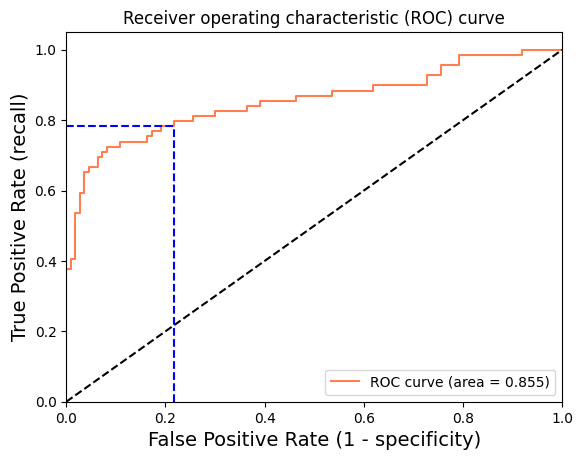

Using a threshold of 0.406 guarantees a sensitivity of 0.783 and a specificity of 0.782, i.e. a false positive rate of 21.82%.


In [117]:
from sklearn.metrics import roc_curve, accuracy_score, log_loss, auc

[fpr, tpr, thr] = roc_curve(y_val, y_pred_proba)
print('Train/Test split results:')
print(model.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_val, y_pred))
print(model.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba))
print(model.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

i = np.arange(len(tpr))
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thr' : pd.Series(thr, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

mythr = list(roc_t['thr'])
idx = np.min(np.where(thr == mythr)) # index of the optimal threshold



# idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +
      "and a specificity of %.3f" % (1-fpr[idx]) +
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

## See cofficients

In [118]:
coefs = pd.DataFrame(data=model.coef_[0].tolist(), index=num_vars+cat_vars_oh, columns=["Coefs"]).sort_values(by="Coefs")
coefs

,Coefs
Sex_male,-1.335175
Pclass,-0.890354
Age,-0.415987
Embarked_S,-0.257046
SibSp,-0.253253
Embarked_Q,-0.095504
Parch,-0.061410
Fare,0.044896
Embarked_C,0.165794
Embarked_missing,0.179517


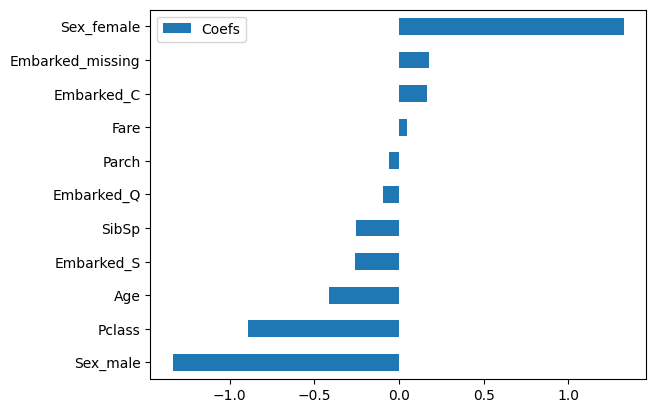

In [119]:
coefs.plot.barh();

In [120]:
columns=num_vars+cat_vars_oh

In [121]:
import math
odds = [math.exp(x) for x in model.coef_[0]]

coef = dict(zip(columns, zip(model.coef_[0], odds)))

data = {'Variable':columns,
        'Coeficiente':model.coef_[0],
        'OR': odds}

data = pd.DataFrame(data)
data

,Variable,Coeficiente,OR
0,Pclass,-0.890354,0.410510
1,Age,-0.415987,0.659689
2,SibSp,-0.253253,0.776272
3,Parch,-0.061410,0.940438
4,Fare,0.044896,1.045919
5,Sex_female,1.327937,3.773251
6,Sex_male,-1.335175,0.263112
7,Embarked_C,0.165794,1.180330
8,Embarked_Q,-0.095504,0.908915
9,Embarked_S,-0.257046,0.773333
